In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import warnings as w
import sys
sys.path.append("../../..")
import Thermobar as pt

## Their parameters
- Cpx-only Use mytry of 6, counter to package default, mtry of 1/3 total number of variables. Use ntree of 201
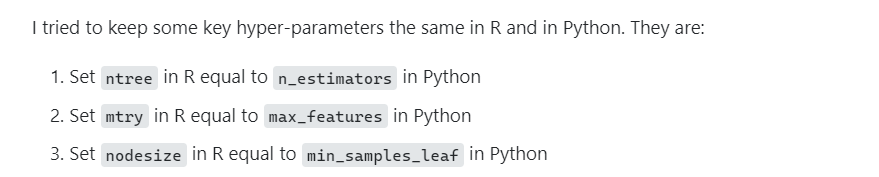
- Cpx-Liq, use mtry of 2/3 of variable. 
- Use 1 cut
- Preprocess the claibration data - use structural formula of Deer et al. 1997. Convert FE2O3 and FeO , go to 100 anhydrous.
- But dont seem to use this?
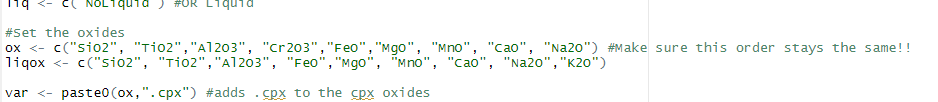

In [4]:
out_train=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='Jorgenson_Input_filtered_ThBar')
out_train_input=out_train['my_input']
Cpx_train=out_train['Cpxs']
Cpx_train_noID_noT=Cpx_train.drop(['Sample_ID_Cpx'], axis=1)
x_train=Cpx_train_noID_noT.values
y_train_T=out_train_input['T_K']
y_train_P=out_train_input['P_kbar']
Kd_Corin_train=(
    (out_train_input['FeOt_Cpx']/out_train_input['MgO_Cpx'])
/(out_train_input['FeOt_Liq']/out_train_input['MgO_Liq'])
)

In [5]:
# Scaling
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)

# Define the regressor, in our case the Extra Tree Regressor
# Using the parameters from Petrelli supplement for P. Don't actually present a regression for T, 
# but we add it here.
regr_T = ExtraTreesRegressor(n_estimators=201, criterion='squared_error', max_features=6, 
                           
                             random_state=120) # random_state fixed for reproducibility

# Define the regressor, in our case the Extra Tree Regressor
regr_P = ExtraTreesRegressor(n_estimators=201, criterion='squared_error', max_features=6, 
                             
                             random_state=120) # random_state fixed for reproducibility

# Train the model
regr_T.fit(x_train_scaled, y_train_T.ravel())
regr_P.fit(x_train_scaled, y_train_P.ravel())


#x_test_scaled=scaler.transform(x_test)

ExtraTreesRegressor(max_features=6, n_estimators=201, random_state=120)

In [6]:
from pickle import dump
dump(scaler, open('scaler_Jorg21_Cpx_only_April24.pkl', 'wb'))


import joblib
joblib.dump(regr_P,  'ETR_Press_Jorg21_Cpx_only_April24.pkl',compress=3)

joblib.dump(regr_T,  'ETR_Temp_Jorg21_Cpx_only_April24.pkl',compress=3)

['ETR_Temp_Jorg21_Cpx_only_April24.pkl']

In [3]:
a=pt.calculate_cpx_only_press(cpx_comps=Cpx_train,
                            equationP="P_Jorgenson2022_Cpx_only")

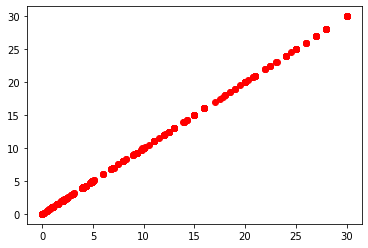

In [4]:
plt.plot(a['P_kbar_calc'], out_train_input['P_kbar'], 'or')

In [5]:
print(0.27359757069089724-0.11797976678485665)
print(min(Kd_Corin_train))
print(0.27359757069089724+0.11797976678485665)
print(max(Kd_Corin_train))

0.15561780390604057
0.1590909090909091
0.3915773374757539
0.3915108177484415


## Unfiltered data

In [6]:
out_unfilt=pt.import_excel('Jorgenson_Input_unfiltered.xlsx',
                          sheet_name='Jorgenson_Input_unfiltered')
out_unfilt_input=out_unfilt['my_input']
Cpx_unfilt=out_unfilt['Cpxs']
Cpx_unfilt_noID_noT=Cpx_unfilt.drop(['Sample_ID_Cpx'], axis=1)
x_unfilt=Cpx_unfilt_noID_noT.values
y_unfilt_T=out_unfilt_input['T_K']
y_unfilt_P=out_unfilt_input['P_kbar']

Kd_Corin=(
    (out_unfilt_input['FeOt_Cpx']/out_unfilt_input['MgO_Cpx'])
/(out_unfilt_input['FeOt_Liq']/out_unfilt_input['MgO_Liq'])
)

sigma_Corin=np.nanstd(Kd_Corin)
print(sigma_Corin)
Mean_Corin=np.nanmean(Kd_Corin)
print(Mean_Corin)
WithinBounds=(Kd_Corin>(Mean_Corin-sigma_Corin))&(Kd_Corin<(Mean_Corin+sigma_Corin))

0.11797976678485665
0.27359757069089724


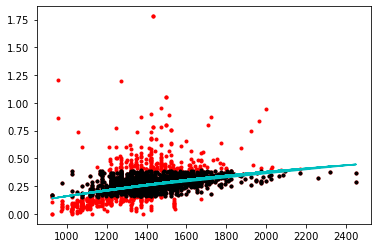

In [7]:
Pred_Kd=np.exp( -0.107 - 1719 / out_unfilt_input['T_K'])
DeltaKD=Kd_Corin-Pred_Kd
plt.plot(out_unfilt_input['T_K'], Kd_Corin,  '.r')
plt.plot(out_unfilt_input['T_K'].loc[WithinBounds], Kd_Corin.loc[WithinBounds],  '.k')
plt.plot(out_unfilt_input['T_K'], Pred_Kd, '-c')

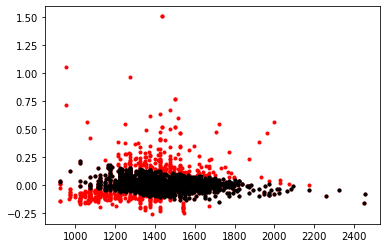

In [8]:
plt.plot(out_unfilt_input['T_K'], DeltaKD,  '.r')
plt.plot(out_unfilt_input['T_K'].loc[WithinBounds], DeltaKD.loc[WithinBounds],  '.k')

## Unique references
- Ones not in their dataset that I have: Blatter et al., 2017, 2013; Bogaerts et al., 2006; Cadoux et al., 2014; Costa, 2004; Erdmann and Koepke, 2016; Erdmann et al., 2016; Firth et al., 2019; Hamada and Fujii, 2008;Mandler et al., 2014;Parman et al., 2011; Pichavant and Macdonald, 2007; Rader and Larsen, 2013; Riker et al., 2015; Ulmer et al., 2018 and Waters et al., 2021; Rutherford et al., 1985; Sisson et al., 2005

ExtraTreesRegressor(max_features=6, n_estimators=201, random_state=120)

## Saving data the old fashion way

['ETR_Temp_Jorg21_Cpx_only_April24.pkl']

In [19]:
equationP="Jorgenson"
if ('Petrelli' in equationP or "Jorgenson" in equationP) and "onnx" in equationP:
    print('yes')
else:
    print('No')

No


In [ ]:
    if ('Petrelli' in equationP or "Jorgenson" in equationP) and "onnx" not in equationP:
        df_stats=func(cpx_comps=cpx_comps_c)

    elif ('Petrelli' in equationP or "Jorgenson" in equationP) and "onnx" in equationP:
        P_kbar=func(cpx_comps=cpx_comps_c)
        
## Temperature ones

if ('Petrelli' in equationT or "Jorgenson" in equationT) and "onnx" not in equationT:

In [87]:
## New test data
out_test=pt.import_excel('Jorgenson_Input_filtered.xlsx',
                          sheet_name='New_Test_Data')
out_test_input=out_test['my_input']
Cpx_test=out_test['Cpxs']
Cpx_test_noID_noT=Cpx_test.drop(['Sample_ID_Cpx'], axis=1)
x_test=Cpx_test_noID_noT.values
y_test_T=out_test_input['T_K_x']
y_test_P=out_test_input['P_kbar_x']
Kd_Corin_test=(
    (out_test_input['FeOt_Cpx']/out_test_input['MgO_Cpx'])
/(out_test_input['FeOt_Liq']/out_test_input['MgO_Liq'])
)

x_test_scaled=scaler.transform(x_test)

## Predicting the test data for temp

'RMSE= 102.20009'

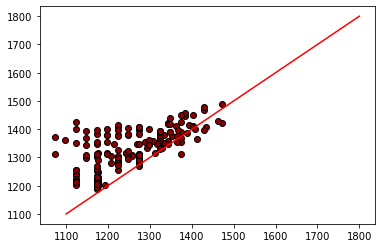

In [88]:
predicted_T=regr_T.predict(x_test_scaled)
plt.plot( y_test_T, predicted_T, 'ok', mfc='darkred')
plt.plot([1100, 1800], [1100, 1800], '-r')
Stats_T=pt.calculate_R2_np(y_test_T.values, predicted_T)
Stats_T['R2']
Stats_T['RMSE']

## Predicting the test data for Press

(0.0, 15.0)

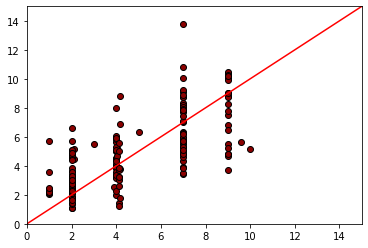

In [90]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)
Stats_P['R2']
Stats_P['RMSE']
plt.xlim([0, 15])
plt.ylim([0, 15])

In [9]:
y_test_P

0       2.0
1       2.0
2       2.0
3       9.0
4       9.0
       ... 
114     5.0
115     5.0
116     5.0
117    30.0
118    30.0
Name: P_GPa, Length: 119, dtype: float64

In [10]:
Stats_P=pt.calculate_R2_np(y_test_P.values, predicted_P)
print(Stats_P['R2'])
print(Stats_P['RMSE'])

R20.95
RMSE= 3.11113


R20.59
RMSE= 1.90889


(0.0, 15.0)

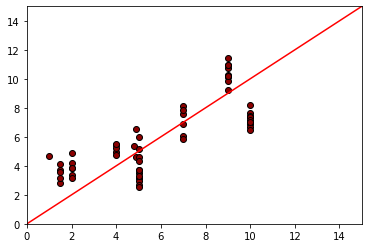

In [11]:
predicted_P=regr_P.predict(x_test_scaled)
plt.plot( y_test_P, predicted_P, 'ok', mfc='darkred')
plt.plot([0, 30], [0, 30], '-r')
lowP=y_test_P<15
Stats_P=pt.calculate_R2_np(y_test_P.loc[lowP].values, predicted_P[lowP])
print(Stats_P['R2'])
print(Stats_P['RMSE'])
plt.xlim([0, 15])
plt.ylim([0, 15])

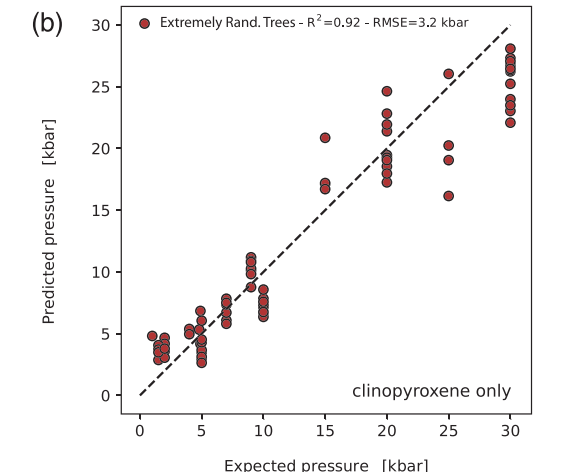

In [12]:
scaler

StandardScaler()

['ETR_Press_Petrelli2020_Cpx_Only_Jan22.pkl']

['ETR_Temp_Petrelli2020_Cpx_Only_Jan22.pkl']